In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer, text_to_word_sequence

from sklearn.manifold import TSNE
%matplotlib inline

In [3]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

****
### EXTRA INVESTIGATIONS
#### DEP
    [ ] dep_id

#### META
    [ ]

#### ALL
    [ ] export as file


### Sunday 12 March DONE [x]


    


TO DO FOR the WEEK: <br>
    - add function to remove stopwords from pos_id X
1. og statement -> get pos -> pos_id
	- train_data['pos_id'] = train_data['statement'].apply(get_pos)

2. og statement -> # preprocess statement: words lemmatized and stopwords are removed -> pred_statement
	- train_data['pred_statement'] = train_data['statement'].apply(preprocess_statement)

3. pred_statement -> add to vocab dict: add preprocessed statements to vocab dict -> vocab_dict
	- vocabulary_dict = load_statement_vocab_dict(train_data)

4. vocab_dict, pred_statement -> getWordID(): turn preprocessed statements to vector -> val
	- train_data['word_id'] = train_data['pred_statement'].apply(lambda x: getWordId(x, vocabulary_dict)

**NOTE** it is generally fine to add pos tags without stopwords removed.
	in siddarthhari, padding used to put pos tags as separate input layer.

15 mar: <br>
    - extracted getWordId() from preprocess_statement()

### 19 March DONE


TODO: 
1. POS tags - incorporate stop words into pos tags 
- update: no need since separate input.
2. preprocess_statement() - configure best ones. confirm lemmatizer works

# Headers

## Header 1 
### Header 2

#### Styles
*Italic*, **bold**, _underscore_, ~~strikethrough~~

#### Hyperlink
[hyperlink](https://www.markdownguide.org/)

#### Table
| Default | Left-aligned | Center-aligned | Right-aligned |
|---------|:-------------|:--------------:|--------------:|
| Default | Left | Center | Right |

#### Others
* Bulleted item 1
    * Bulleted subitem 1
* Bulleted item 2

***
    1. Ordered item 1
        1.1. Ordered subitem 1
    2. Ordered item 2

***
    [ ] Unchecked box
    [x] Checked box

# Preprocessing

## Functions

    ADJ: Adjective - a word that describes a noun or pronoun. Examples: "red", "happy", "big"
    ADP: Adposition - a word that expresses a relationship between a noun or pronoun and other words in a sentence. Examples: "in", "on", "at"
    ADV: Adverb - a word that modifies a verb, adjective, or other adverb. Examples: "quickly", "very", "well"
    AUX: Auxiliary verb - a verb used in combination with a main verb to express tense, aspect, modality, or voice. Examples: "is", "have", "will"
    CONJ: Coordinating conjunction - a word that connects words, phrases, or clauses of equal importance. Examples: "and", "or", "but"
    DET: Determiner - a word that introduces a noun and provides information about the quantity or identity of the noun. Examples: "the", "a", "some"
    INTJ: Interjection - a word or phrase that expresses strong emotion or surprise. Examples: "oh", "wow", "ouch"
    NOUN: Noun - a word that refers to a person, place, thing, or idea. Examples: "dog", "house", "happiness"
    NUM: Numeral - a word that represents a number or quantity. Examples: "one", "two", "hundred"
    PART: Particle - a word that functions as an auxiliary to a verb or as a discourse marker. Examples: "not", "to", "up"
    PRON: Pronoun - a word that takes the place of a noun or noun phrase. Examples: "he", "she", "it"
    PROPN: Proper noun - a noun that refers to a specific person, place, or thing. Examples: "New York", "John", "Nike"
    PUNCT: Punctuation - a character or mark used in writing to separate sentences, clauses, or phrases, or to indicate pauses or intonation. Examples: ".", ",", "!"
    X: Other - a catch-all category for words that don't fit into any other part-of-speech category. Examples: foreign words, abbreviations, etc.
    SCONJ: Subordinating conjunction - a word that connects a dependent clause to an independent clause. Examples: "although", "because", "unless"
    SYM: Symbol - a character or glyph that represents a specific meaning or concept. Examples: "$", "%", "#"
    VERB: Verb - a word that describes an action or state of being. Examples: "run", "think", "be"

In [4]:
pos_tags = { 'ADJ': 'adjective', 'ADP': 'adposition', 'ADV': 'adverb', 'AUX': 'auxiliary verb', 'CONJ': 'coordinating conjunction',
                    'DET': 'determiner', 'INTJ': 'interjection', 'NOUN': 'noun',  'NUM': 'numeral', 'PART': 'particle', 'PRON': 'pronoun',
                    'PROPN': 'proper noun', 'PUNCT': 'punctuation', 'X': 'other', 'SCONJ': 'subordinating conjunction', 'SYM': 'symbol', 'VERB': 'verb'}

# proposed pos_dict: values correspond to pos tag importance
posdict_custom = {'NOUN': 0, 'VERB': 1, 'ADJ': 2, 'ADV': 3, 'ADP': 4, 'PRON': 5,
                    'NUM': 6, 'SCONJ': 7, 'PROPN': 8, 'CONJ': 9, 'PUNCT': 10, 'AUX': 11,
                    'PART': 12, 'INTJ': 13, 'DET': 14, 'SYM': 14, 'X': 14}

posdict_default = {'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CONJ': 4,
            'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9,
            'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'X': 13,  'SCONJ': 14, 'SYM': 15, 'VERB': 16}

In [5]:
from collections import defaultdict

def get_pos(statement, pos_dict):
    # create a defaultdict object that returns max(pos_dict.values())+1
    # as the default value for any key (POS label) that is not found
    tag_dict = defaultdict(lambda: max(pos_dict.values())+1, pos_dict)
    tag_list = [tag_dict[token.pos_] for token in nlp(statement)]
    return tag_list


In [6]:
def preprocess_statement(statement, pos_remove=None, spacy_stopword_removal=False):
# lemmatizes and lowercases tokens that are not punctuation or whitespace.
# params: statement - string
#         exclude_pos - list of POS tags to exclude from word list
#         remove_stopwords - removes stopwords based on pretrained spacy model
#         **warning** not recommended to toggle both params to True
# returns: tokens joined into a string
    doc = nlp(statement)
    words = []
    for token in doc:
        # check if token should be excluded based on part of speech or stopword status
        if pos_remove and token.pos_ in pos_remove:
            continue
        if spacy_stopword_removal and token.is_stop:
            continue
        # only include tokens that are not punctuation or whitespace
        if not token.is_punct and not token.is_space:
            # lemmatize and lowercase
            words.append(token.lemma_.lower())
    return ' '.join(words)

In [7]:
def preprocess_statement(statement, pos_remove=None, spacy_stopword_removal=False):
    # lemmatizes and lowercases tokens that are not punctuation or whitespace.
    # params: statement - string
    # exclude_pos - list of POS tags to exclude from word list
    # remove_stopwords - removes stopwords based on pretrained spacy model
    # **warning** not recommended to toggle both params to True
    # returns: tokens joined into a string

    words = (token.lemma_.lower() for token in nlp(statement)
             if not token.is_punct and not token.is_space and
             (not pos_remove or token.pos_ not in pos_remove) and
             (not spacy_stopword_removal or not token.is_stop))

    return ' '.join(words)


In [8]:
def create_statement_vocab_dict(data, column_name):
    vocab_file_name = f"vocabulary_{column_name}.p"

    if os.path.exists(vocab_file_name):
        with open(vocab_file_name, "rb") as f:
            old_vocabulary_dict = pickle.load(f)
        # Check length of existing vocabulary dictionary and length of vocabulary dictionary created from the text data
        if len(old_vocabulary_dict) == len(set(data[column_name].str.split().sum())):
            print(f"Using existing Vocabulary Dictionary for column {column_name}...")
            return old_vocabulary_dict

        # If the length is different, delete the existing vocabulary dictionary file
        else:
            os.remove(vocab_file_name)
            print(f"Deleted existing Vocabulary Dictionary for column {column_name}...")

    # Create a new tokenizer object and fit it on the text data for the specified column
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data[column_name])

    vocabulary_dict = tokenizer.word_index
    print(f"Created Vocabulary Dictionary for column {column_name}.")
    print('Size: ' + str(len(vocabulary_dict)))

    # Save the vocabulary dictionary to a file
    with open(vocab_file_name, "wb") as f:
        pickle.dump(vocabulary_dict, f)
    print(f"Saved Vocabulary Dictionary as {vocab_file_name}")
    return vocabulary_dict


In [9]:
# preprocessed statement to vector
def getWordId(pred_statement, vocabulary_dict):
    text = text_to_word_sequence(pred_statement)
    val = [vocabulary_dict[t] for t in text if t in vocabulary_dict]
    return val

In [10]:
def print_row_info(row_num, df):
    print(f"#### label #####\n{df.loc[row_num, 'label']}")
    print(f"#### original statement #####\n{df.loc[row_num, 'statement']}")
    print(f"#### pos_id #####\n{df.loc[row_num, 'pos_id']}")
    print(f"#### custom stopwords #####\n{df.loc[row_num, 'statement_custom']}")
    print(f"#### word_id #####\n{df.loc[row_num, 'word_id_custom']}")
    print(f"#### spacy stopwords #####\n{df.loc[row_num, 'statement_spacy']}")
    print(f"#### spacy word_id #####\n{df.loc[row_num, 'word_id_spacy']}")

In [11]:
def clean_data(data, label_map):
    # maps labels to numerical values to 'output' column
    data['output'] = data['label'].apply(lambda x: label_map[x])

    # replace missing values in 'subject' and 'speaker' with empty strings
    data['subject'] = data['subject'].fillna('')
    data['speaker'] = data['speaker'].fillna('')

    # drop rows where there are missing values in 'statement'
    data.drop(index=data[data.statement==' '].index, inplace=True)
    data.drop(index=data[data.statement=='  '].index, inplace=True)
    data.drop(index=data[data.statement=='\n'].index, inplace=True)

    # drop context column
    data.drop(columns=['context'], inplace=True)
    data.drop(columns=['id'], inplace=True)
    # data.drop(columns=['state info'], inplace=True)
    # data.drop(columns=['party'], inplace=True)

    # reset index
    data = data.reset_index()

    return data

## DataFrame Cleaning

- train_data['label'] -> num values
- drops all rows where 'subject' and 'speaker' columns are missing
- drops all rows that have missing values in 'statement'
- drops context column

<h3>Mar 19 todo:</h3>

- refactor to single function
- instead of dropping rows, replace missing values in 'subject' and 'speaker' as empty string

In [12]:
# column titles and label maps
columns = ['id','label','statement','subject','speaker','job title','state info','party','barely true','false','half-true','mostly-true','pants-on-fire','context']
label_map = {'pants-fire':-3, 'false':-2, 'barely-true':-1, 'half-true':1, 'mostly-true':2, 'true':3}

In [13]:
# load dataset files as pandas dataframes
train_data = pd.read_csv('train.tsv', sep='\t', header=None, names=columns)
val_data = pd.read_csv('valid.tsv', sep='\t', header=None, names=columns)
test_data = pd.read_csv('test.tsv', sep='\t', header=None, names=columns)
# train_data.head()

In [14]:
train_data = clean_data(train_data, label_map)
val_data = clean_data(val_data, label_map)
test_data = clean_data(test_data, label_map)

In [15]:
train_data.head()

,index,label,statement,subject,speaker,job title,state info,party,barely true,false,half-true,mostly-true,pants-on-fire,output
0,0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,-2
1,1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,1
2,2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,2
3,3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,-2
4,4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,1


In [16]:
print('real news count')
train_data[train_data['output']>0].count()

real news count


index            5752
label            5752
statement        5752
subject          5752
speaker          5752
job title        4264
state info       4663
party            5752
barely true      5752
false            5752
half-true        5752
mostly-true      5752
pants-on-fire    5752
output           5752
dtype: int64

### for this experiment, siddarth's results will be used as benchmark.


#### to test the different preprocessing methods, the following experiments will be run:
1. siddarth - baseline
    - ogdict
    - nltk stopword removal only
2. fathan - pos tag check
    - dict1
    - spacy stopword removal only
    - glove
3. fathan - preprocess
    - dict1
    - full preprocessing
    - glove

## GET pos tag

In [17]:
train_data['pos_id'] = train_data['statement'].apply(get_pos, pos_dict=posdict_custom)
train_data['pos_id_DEFAULT'] = train_data['statement'].apply(get_pos, pos_dict=posdict_default)

val_data['pos_id'] = val_data['statement'].apply(get_pos, pos_dict=posdict_custom)
val_data['pos_id_DEFAULT'] = val_data['statement'].apply(get_pos, pos_dict=posdict_default)

test_data['pos_id'] = test_data['statement'].apply(get_pos, pos_dict=posdict_custom)
test_data['pos_id_DEFAULT'] = test_data['statement'].apply(get_pos, pos_dict=posdict_default)

In [18]:
# train_data.head()

## GET Preprocess statements and word_id

In [19]:
# custom list of pos tags to remove as stopwords in statement_custom
pos_exclusion_list = ['SYM', 'DET', 'X', 'PRON', 'PART', 'CONJ', 'ADP']

train_data['statement_custom'] = train_data['statement'].apply(preprocess_statement,
                                                               pos_remove=pos_exclusion_list,
                                                               spacy_stopword_removal=False)
train_data['statement_spacy'] = train_data['statement'].apply(preprocess_statement,
                                                              pos_remove=None,
                                                              spacy_stopword_removal=True)

val_data['statement_custom'] = val_data['statement'].apply(preprocess_statement,
                                                           pos_remove=pos_exclusion_list,
                                                           spacy_stopword_removal=False)
val_data['statement_spacy'] = val_data['statement'].apply(preprocess_statement,
                                                          pos_remove=None,
                                                          spacy_stopword_removal=True)

test_data['statement_custom'] = test_data['statement'].apply(preprocess_statement,
                                                               pos_remove=pos_exclusion_list,
                                                               spacy_stopword_removal=False)
test_data['statement_spacy'] = test_data['statement'].apply(preprocess_statement,
                                                              pos_remove=None,
                                                              spacy_stopword_removal=True)

In [20]:
# train_data.head()

In [21]:
vocabulary_dict_custom = create_statement_vocab_dict(train_data, 'statement_custom')
vocabulary_dict_spacy = create_statement_vocab_dict(train_data, 'statement_spacy')

Deleted existing Vocabulary Dictionary for column statement_custom...
Created Vocabulary Dictionary for column statement_custom.
Size: 9606
Saved Vocabulary Dictionary as vocabulary_statement_custom.p
Deleted existing Vocabulary Dictionary for column statement_spacy...
Created Vocabulary Dictionary for column statement_spacy.
Size: 9495
Saved Vocabulary Dictionary as vocabulary_statement_spacy.p


In [22]:
# vocab_file_name = "vocabulary_pred_statement.p"
# train_data['word_id'] = train_data['pred_statement'].apply(lambda x: getWordId(x, vocab_file_name))

In [23]:
train_data['word_id_custom'] = train_data['statement_custom'].apply(lambda x: getWordId(x,
                                                                                        vocabulary_dict_custom))
train_data['word_id_spacy'] = train_data['statement_spacy'].apply(lambda x: getWordId(x,
                                                                                      vocabulary_dict_spacy))

val_data['word_id_custom'] = val_data['statement_custom'].apply(lambda x: getWordId(x,
                                                                                    vocabulary_dict_custom))
val_data['word_id_spacy'] = val_data['statement_spacy'].apply(lambda x: getWordId(x,
                                                                                  vocabulary_dict_spacy))

test_data['word_id_custom'] = test_data['statement_custom'].apply(lambda x: getWordId(x,
                                                                                        vocabulary_dict_custom))
test_data['word_id_spacy'] = test_data['statement_spacy'].apply(lambda x: getWordId(x,
                                                                                      vocabulary_dict_spacy))
# val_data['word_id'] = val_data['pred_statement'].apply(lambda x: getWordId(x, vocabulary_dict))
# test_data['word_id'] = test_data['pred_statement'].apply(lambda x: getWordId(x, vocabulary_dict))
# train_data.drop('pred_statement', axis=1, inplace=True)

In [40]:
train_data.head()

,index,label,statement,subject,speaker,job title,state info,party,barely true,false,half-true,mostly-true,pants-on-fire,output,pos_id,pos_id_DEFAULT,statement_custom,statement_spacy,word_id_custom,word_id_spacy
0,0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,-2,"[1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]","[16, 5, 11, 11, 0, 7, 16, 0, 12, 7, 7, 1, 7, 12]",say annies list political group support third ...,say annies list political group support trimes...,"[3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...","[1, 5315, 633, 423, 332, 37, 3919, 120, 936]"
1,1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,1,"[7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...","[14, 16, 5, 7, 1, 7, 7, 12, 10, 16, 14, 0, 7, ...",when do decline coal start start when natural ...,decline coal start start natural gas take star...,"[37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...","[720, 773, 249, 249, 891, 204, 46, 249, 527, 1..."
2,2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,2,"[8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...","[11, 11, 16, 1, 11, 11, 12, 1, 16, 9, 16, 11, ...",hillary clinton agree john mccain vote give ge...,hillary clinton agree john mccain vote george ...,"[104, 69, 734, 160, 201, 18, 89, 262, 137, 258...","[74, 49, 649, 125, 157, 12, 212, 103, 208, 274..."
3,3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,-2,"[0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]","[7, 7, 7, 7, 3, 0, 9, 16, 0, 7, 7, 7, 12]",health care reform legislation be likely manda...,health care reform legislation likely mandate ...,"[19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...","[13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]"
4,4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,1,"[14, 2, 0, 1, 4, 14, 0, 4, 5, 0, 10]","[5, 0, 7, 16, 1, 5, 7, 1, 10, 7, 12]",economic turnaround start end term,economic turnaround start end term,"[282, 3331, 308, 247, 248]","[224, 3208, 249, 198, 199]"


## SAVING word_id and pos_id and dep_id and meta_id

In [49]:
# def save_ids_as_pickle(data: pd.DataFrame, ids_col: str, split_type: str):
#     ids_np = np.array(data[ids_col].to_list())
#     ids_np_file = f"{split_type}_{ids_col}.p"
#     with open(ids_np_file, 'wb') as f:
#         pickle.dump(ids_np, f)
#     print(f"{ids_col} for {split_type} saved as pickle: {ids_np_file}")

# save_ids_as_pickle(train_data, "word_id_custom", "train", "ids")

In [25]:
# save data as csv
pd.DataFrame(train_data).to_csv('processed_train_data.tsv', sep='\t', index=False)
pd.DataFrame(val_data).to_csv('processed_val_data.tsv', sep='\t', index=False)
pd.DataFrame(test_data).to_csv('processed_test_data.tsv', sep='\t', index=False)

In [43]:
# save custom word_id as PICKLE
train_data['word_id_custom'].to_pickle('train_word_id_custom.p')
val_data['word_id_custom'].to_pickle('val_word_id_custom.p')
test_data['word_id_custom'].to_pickle('test_word_id_custom.p')

In [46]:
# save spacy word_id as PICKLE
train_data['word_id_spacy'].to_pickle('train_word_id_spacy.p')
val_data['word_id_spacy'].to_pickle('val_word_id_spacy.p')
test_data['word_id_spacy'].to_pickle('test_word_id_spacy.p')

In [47]:
# save custom pos_id as PICKLE
train_data['word_id_spacy'].to_pickle('train_pos_id_spacy.p')
val_data['word_id_spacy'].to_pickle('val_pos_id_spacy.p')
test_data['word_id_spacy'].to_pickle('test_pos_id_spacy.p')

In [45]:
# Save custom word id as NUMPY
np.save('train_word_id_custom.npy', train_data['word_id_custom'].values)
np.save('val_word_id_custom.npy', val_data['word_id_custom'].values)
np.save('test_word_id_custom.npy', val_data['word_id_custom'].values)

In [ ]:
# # statement padding

# word_seq_train = np.array(padding(word_seq_train, maxlen=50), dtype='float32')
# word_seq_test = np.array(padding(word_seq_test, maxlen=50), dtype='float32')
# word_seq_valid = np.array(padding(word_seq_valid, maxlen=50), dtype='float32')

# Word Embeddings

In [1]:
print_row_info(388, train_data)

NameError: name 'print_row_info' is not defined

In [27]:
print_row_info(9, train_data)

#### label #####
mostly-true
#### original statement #####
Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.
#### pos_id #####
[1, 8, 2, 0, 8, 8, 15, 8, 8, 1, 14, 0, 0, 5, 1, 14, 6, 6, 4, 2, 0, 0, 10]
#### custom stopwords #####
say gop primary opponent glenn grothman and joe leibham cast compromise vote cost 788 million high electricity cost
#### word_id #####
[3, 579, 538, 546, 1916, 4043, 4, 547, 5445, 1080, 2065, 18, 60, 5446, 17, 43, 1694, 60]
#### spacy stopwords #####
say gop primary opponent glenn grothman joe leibham cast compromise vote cost $ 788 million high electricity cost
#### spacy word_id #####
[1, 502, 462, 469, 1815, 3922, 470, 5320, 988, 1958, 12, 42, 5321, 11, 29, 1592, 42]


In [28]:
def read_glove_embeddings():
    embeddings = {}
    with open("glove.6B.100d.txt", encoding="utf8") as file_object:
        for line in file_object:
            word_embed = line.split()
            word = word_embed[0]
            embed = np.array(word_embed[1:], dtype="float32")
            embeddings[word.lower()] = embed
    return embeddings

# # create embedding matrix for vocabulary_dict1
# num_words1 = len(vocabulary_dict1) + 1
# embedding_matrix1 = np.zeros((num_words1, EMBED_DIM))
#
# for word, i in vocabulary_dict1.items():
#     embedding_vector = embeddings_dict1.get(word)
#     if embedding_vector is not None:
#         embedding_matrix1[i] = embedding_vector
#
# # create embedding matrix for vocabulary_dict2
# num_words2 = len(vocabulary_dict2) + 1
# embedding_matrix2 = np.zeros((num_words2, EMBED_DIM))
#
# for word, i in vocabulary_dict2.items():
#     embedding_vector = embeddings_dict2.get(word)
#     if embedding_vector is not None:
#         embedding_matrix2[i] = embedding_vector


In [29]:
# read GloVe embeddings
embeddings_dict = read_glove_embeddings()
print(len(embeddings_dict), " : Word Embeddings Found")

400001  : Word Embeddings Found


In [30]:
def create_embedding_matrix(vocabulary_dict, embeddings_dictionary, embed_dim):
    num_words = len(vocabulary_dict) + 1
    embedding_matrix = np.zeros((num_words, embed_dim))

    for word, i in vocabulary_dict.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [3]:
# CREATE AND EXPORT EMBEDDING MATRIXES
EMBED_DIM = 100
embedding_matrix_custom = create_embedding_matrix(vocabulary_dict_custom, embeddings_dict, EMBED_DIM)
embedding_matrix_spacy = create_embedding_matrix(vocabulary_dict_spacy, embeddings_dict, EMBED_DIM)

embedding_shape = embedding_matrix_custom.shape

print("Shape of the embedding matrix:", embedding_shape)

NameError: name 'create_embedding_matrix' is not defined

In [32]:
# EXPORT EMBEDDING MATRIXES
np.save('embedding_matrix_custom.npy', embedding_matrix_custom)
np.save('embedding_matrix_spacy.npy', embedding_matrix_spacy)

# Visualize Embeddings

In [33]:
def visualize_embeddings(embedding_matrix,
                         word_index,
                         num_words=500,
                         plot_title='Embedding Visualisation',
                         figsize=(15, 15)):

    # Get the first `num_words` words in the vocabulary
    words = [word for word, i in word_index.items() if i < num_words]

    # Get the corresponding embeddings for these words
    embeddings = embedding_matrix[:num_words]

    # Use t-SNE to reduce the dimensionality of the embeddings to 2
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings as a scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.title(plot_title)
    plt.show()

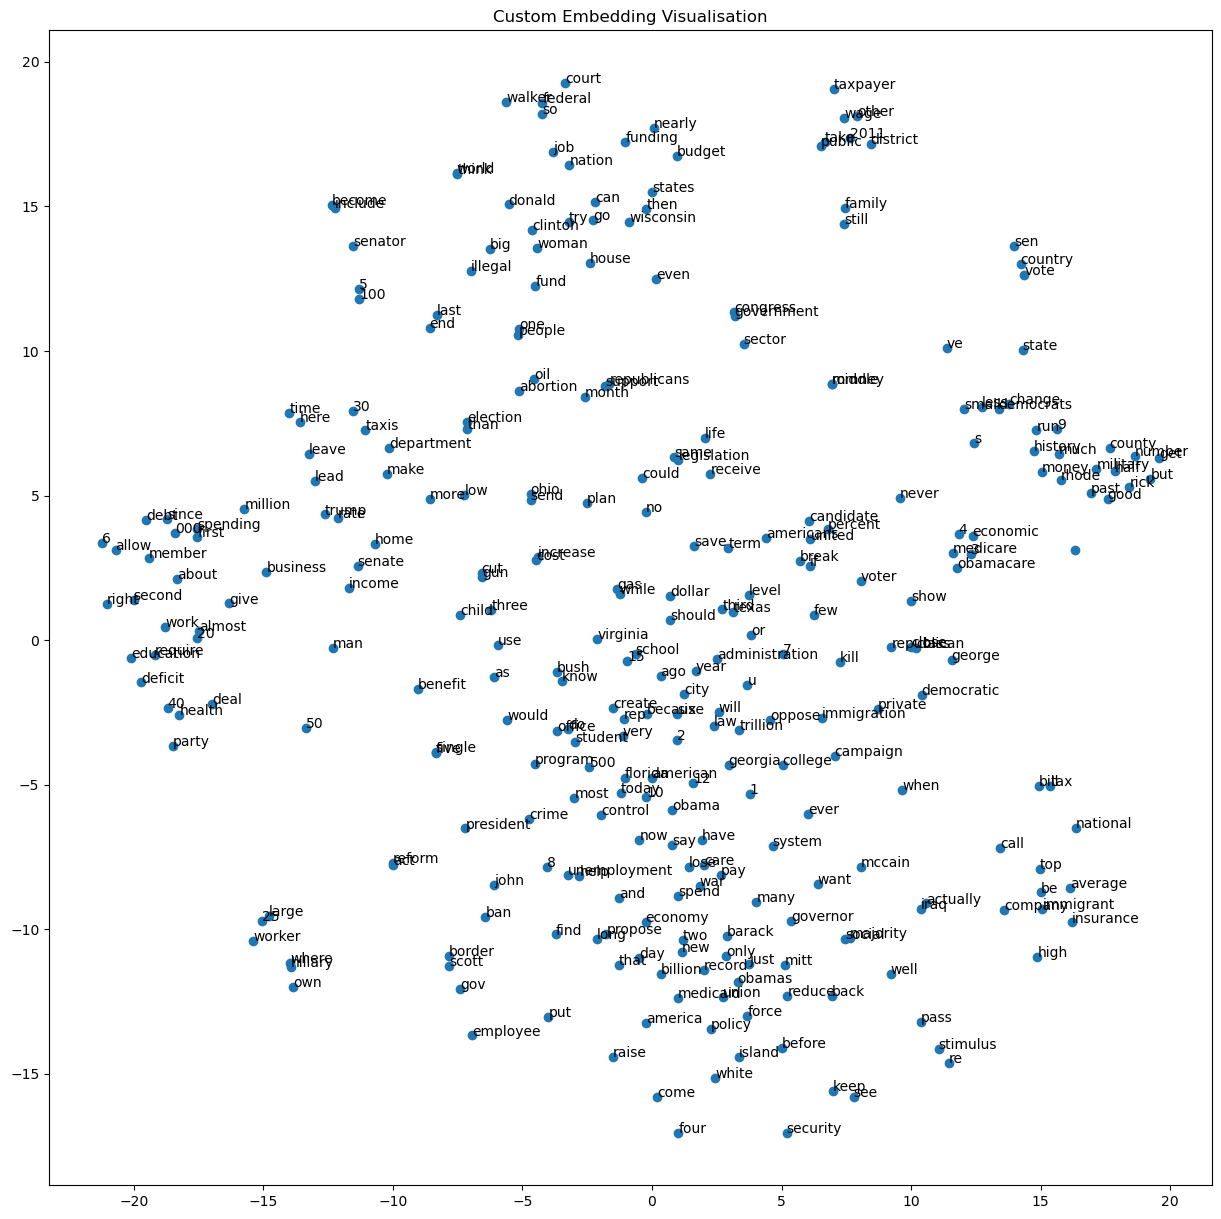

In [34]:
visualize_embeddings(embedding_matrix_custom,
                     vocabulary_dict_custom,
                     num_words=300,
                     plot_title='Custom Embedding Visualisation')


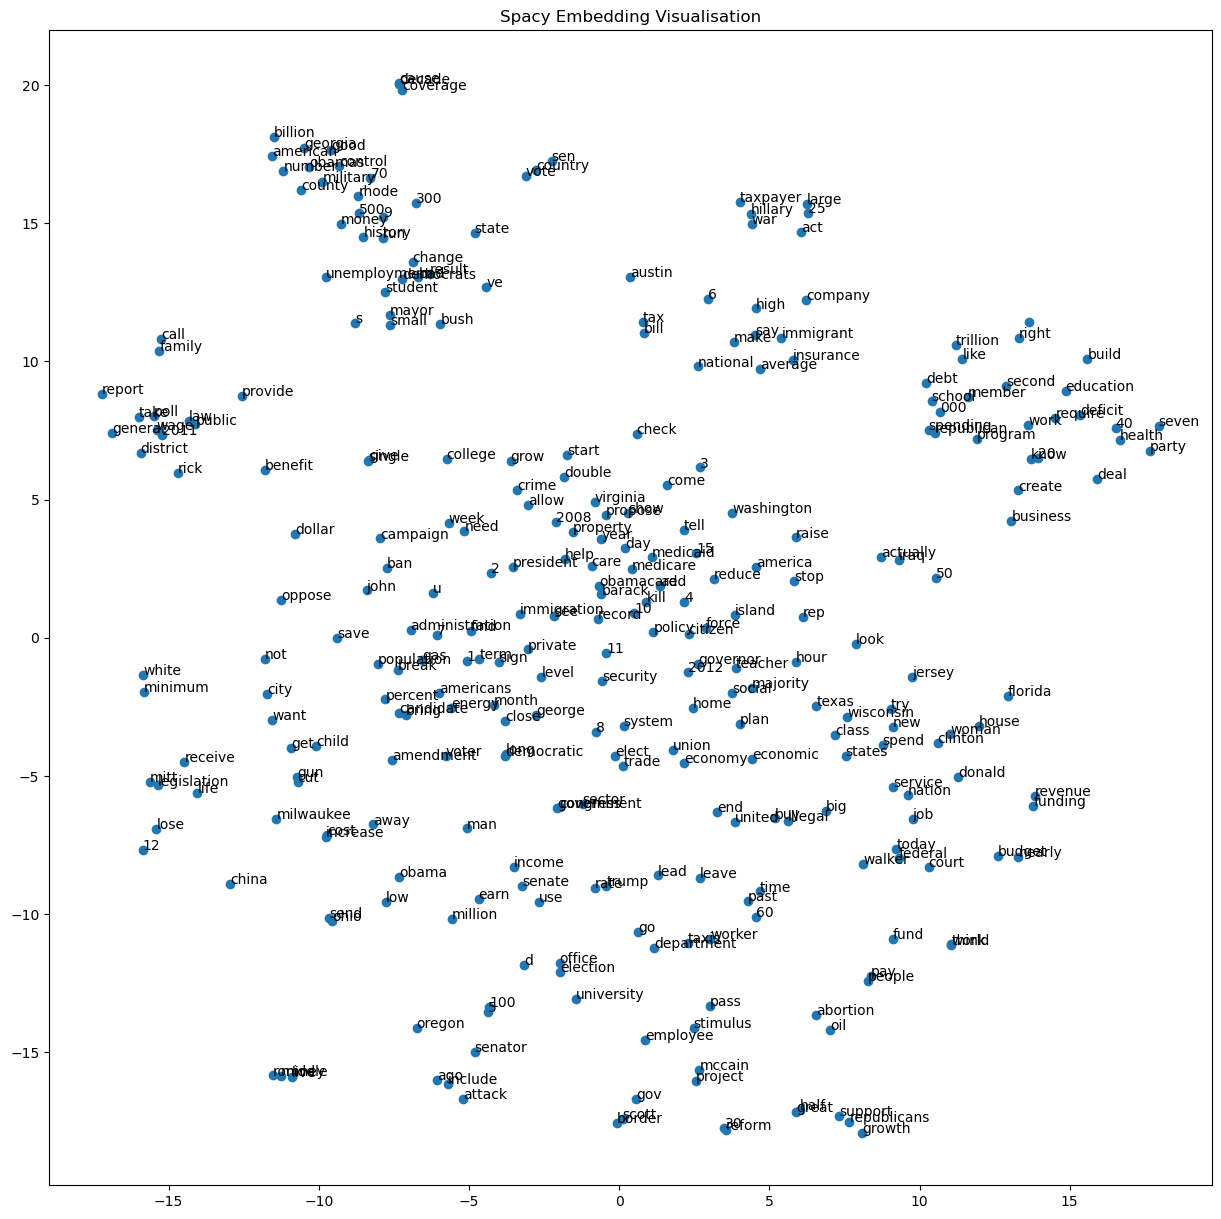

In [36]:
visualize_embeddings(embedding_matrix_spacy,
                     vocabulary_dict_spacy,
                     num_words=300,
                     plot_title='Spacy Embedding Visualisation')

In [38]:
from wordcloud import WordCloud

def plot_word_cloud(vocabulary):

    ## Generate word cloud
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='black',
                          max_words=100
                          ).generate_from_frequencies(vocabulary)

    ## Display word cloud
    plt.figure(figsize=(24,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

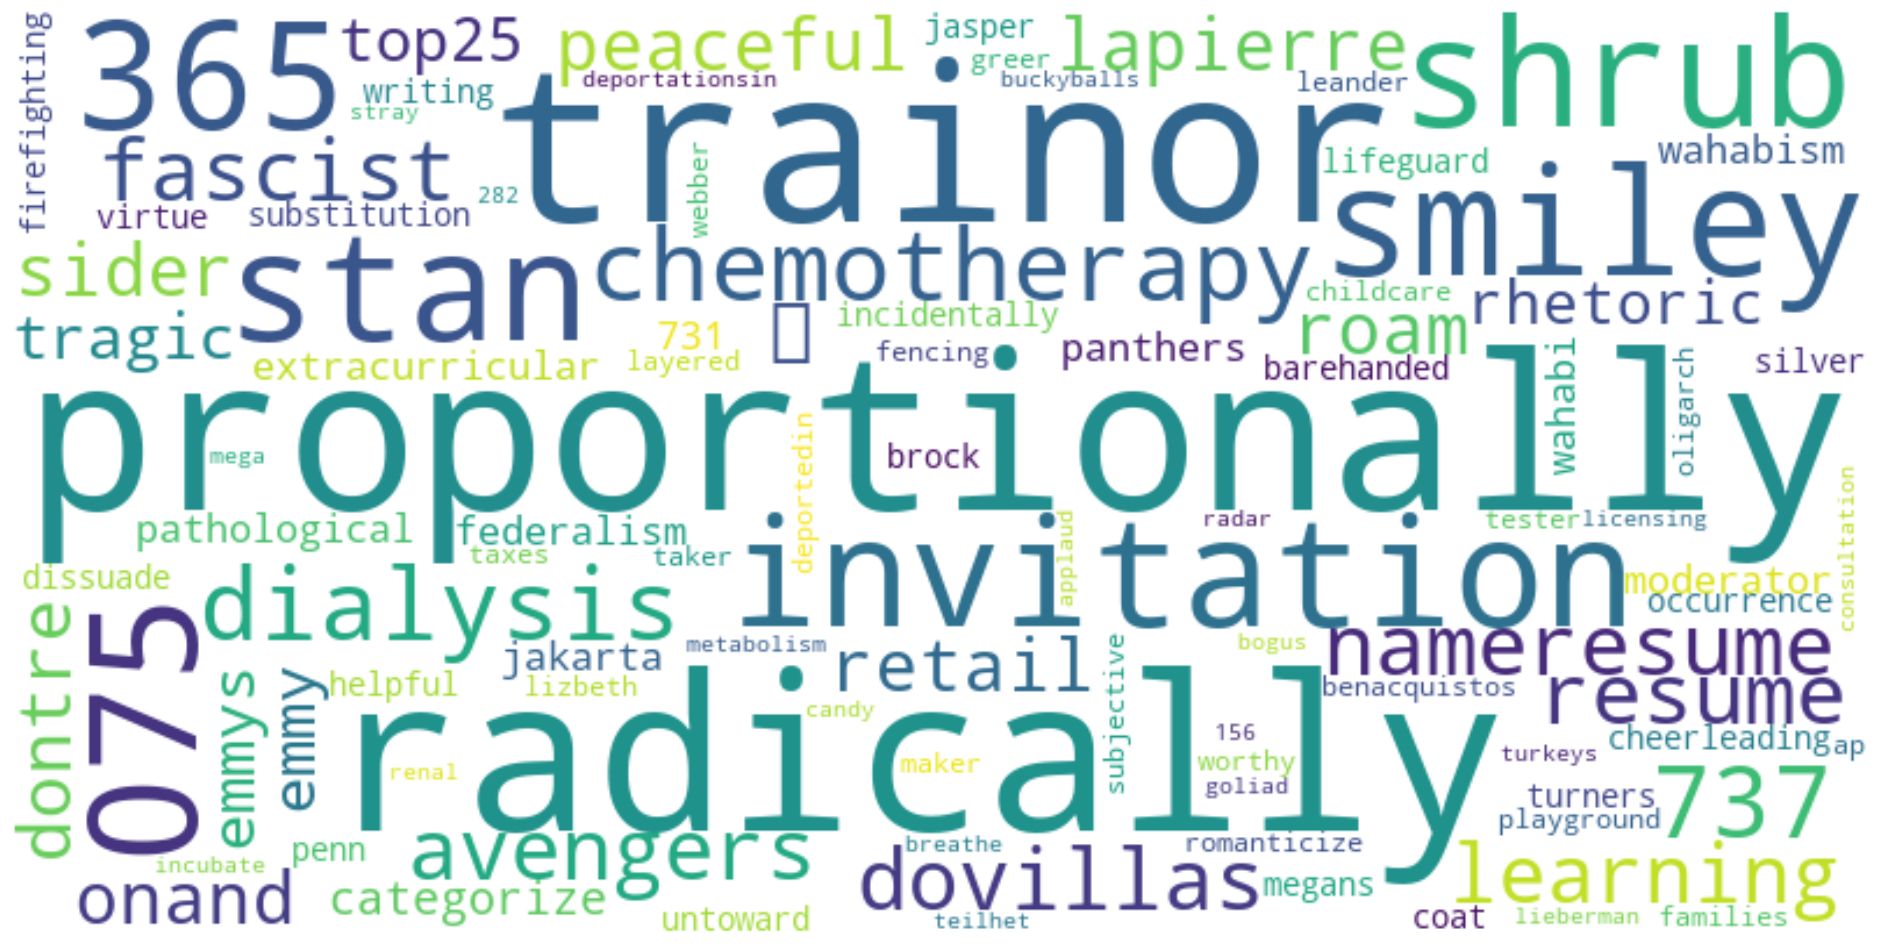

In [39]:
plot_word_cloud(vocabulary_dict_custom)

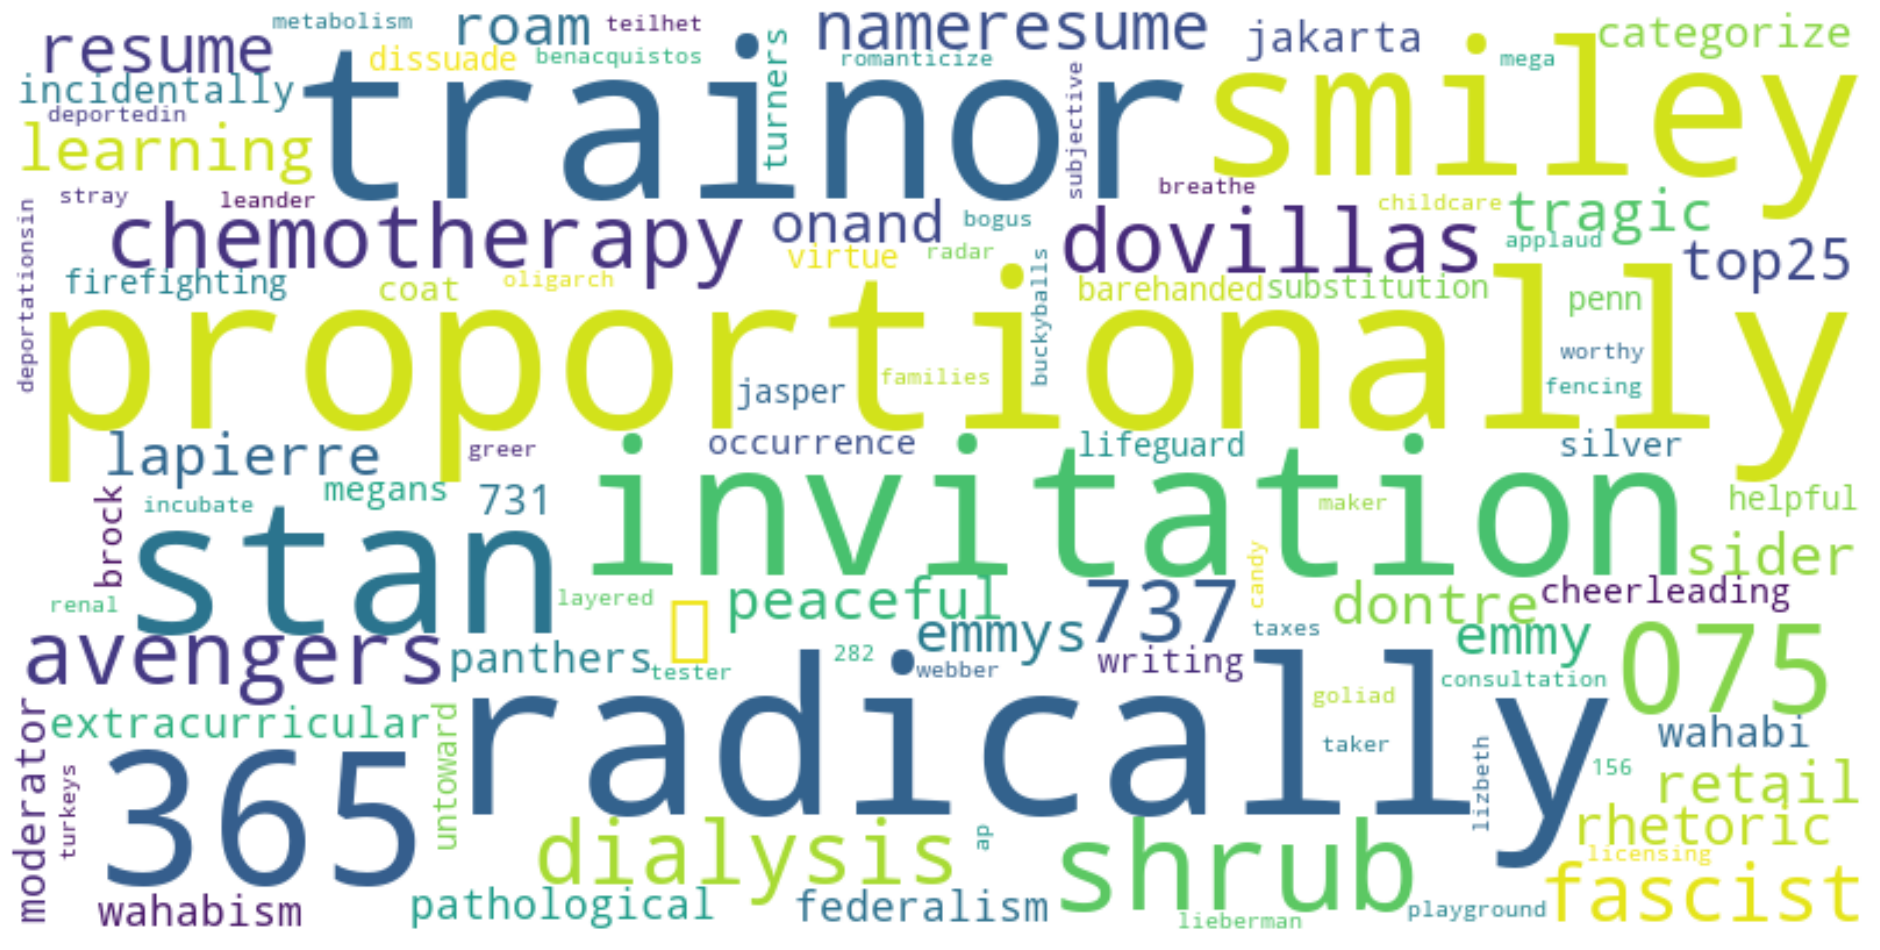

In [40]:
plot_word_cloud(vocabulary_dict_spacy)

#### TODO mar 27
  -  [x] wish mom happy birthday
  -  [ ] separate models into custom and spacy
  -  [ ] decide function vs code cells
  -  [x] cleanup preprocessing
  -  [x] initialise pos tag input
  -  [x] separate notebook into preprocess and model
  -  [x] export data as csv
  -  [x] manage imports


#### Model
1. [ ] if-else vs dictionary?
2. [ ] Train() function

In [51]:
# frequency of most common words in statement_custom
from collections import Counter
cnt = Counter()
for text in train_data["statement_custom"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(50)

[('be', 5642),
 ('have', 3007),
 ('say', 2883),
 ('and', 2851),
 ('year', 1234),
 ('percent', 1190),
 ('state', 1105),
 ('more', 938),
 ('do', 905),
 ('that', 793),
 ('obama', 747),
 ('tax', 706),
 ('job', 650),
 ('president', 647),
 ('million', 639),
 ('vote', 614),
 ('health', 614),
 ('people', 603),
 ('would', 572),
 ('care', 518),
 ('one', 513),
 ('will', 505),
 ('pay', 499),
 ('go', 496),
 ('new', 468),
 ('bill', 462),
 ('time', 441),
 ('or', 439),
 ('get', 436),
 ('billion', 429),
 ('country', 429),
 ('u.s.', 425),
 ('cut', 424),
 ('when', 413),
 ('texas', 393),
 ('take', 385),
 ('only', 383),
 ('law', 379),
 ('taxis', 376),
 ('high', 373),
 ('government', 373),
 ('budget', 370),
 ('rate', 369),
 ('federal', 364),
 ('make', 362),
 ('barack', 358),
 ('since', 352),
 ('if', 345),
 ('now', 337),
 ('school', 333)]

In [39]:
# frequency of most common words in statement_spacy
from collections import Counter
cnt = Counter()
for text in train_data["statement_spacy"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(50)

[('say', 2788),
 ('$', 1280),
 ('year', 1234),
 ('percent', 1190),
 ('state', 1105),
 ('obama', 747),
 ('tax', 706),
 ('job', 650),
 ('president', 647),
 ('million', 639)]

# MODEL
* [x] transfer to bilstm.ipynb

In [ ]:
# # vocab_length = len(vocabulary_dict.keys())
# custom_vocablen = len(vocabulary_dict_custom.keys())
# spacy_vocablen = len(vocabulary_dict_spacy.keys())
# hidden_size = EMBED_DIM #Has to be same as EMBED_DIM
# lstm_size = 100
# num_steps = 15
# num_epochs = 30
# batch_size = 40
#
# #Hyperparams for CNN
# kernel_sizes = [3,3,3]
# filter_size = 128
#
# #Meta data related hyper params
# num_party = len(train_data.party_id.unique())
# num_state = len(train_data.state_id.unique())
# num_venue = len(train_data.venue_id.unique())
# num_job = len(train_data.job_id.unique())
# num_sub = len(train_data.subject_id.unique())
# num_speaker = len(train_data.speaker_id.unique())
# print num_party
# print num_state
# print num_venue
# print num_job
# print num_sub
# print num_speaker
# print train_data.columns

In [ ]:
# # CUSTOM word_id
# ##
# X_train = train_data['word_id_custom']
# X_val = val_data['word_id_custom']
# X_test = test_data['word_id_custom']
#
# Y_train = train_data['output']
# Y_train = keras.utils.to_categorical(Y_train, num_classes=6)
#
# Y_val = val_data['output']
# Y_val = keras.utils.to_categorical(Y_val, num_classes=6)
#
# X_train = sequence.pad_sequences(X_train, maxlen=num_steps, padding='post', truncating='post')
#
# # X_train = sequence.utils.pad_sequences(X_train, maxlen=num_steps, padding='post',truncating='post')
# X_val = sequence.pad_sequences(X_val, maxlen=num_steps, padding='post',truncating='post')

In [ ]:
# # SPACY word_id
# ##
# X_train_spacy = train_data['word_id_spacy']
# X_val_spacy = val_data['word_id_spacy']
# X_test_spacy = test_data['word_id_spacy']
#
# Y_train_spacy = train_data['output']
# Y_train_spacy = keras.utils.to_categorical(Y_train, num_classes=6)
#
# Y_val_spacy = val_data['output']
# Y_val_spacy = keras.utils.to_categorical(Y_val, num_classes=6)
#
# X_train_spacy = sequence.utils.pad_sequences(X_train_spacy, maxlen=num_steps, padding='post',truncating='post')
# X_val_spacy = sequence.pad_sequences(X_val, maxlen=num_steps, padding='post',truncating='post')


In [ ]:
# def create_model(num_words, embedding_dim, embedding_matrix):
#     model = Sequential()
#     model.add(Embedding(num_words,
#                         embedding_dim,
#                         weights=[embedding_matrix],
#                         trainable=False))
#     model.add(Bidirectional(LSTM(128)))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])
#     return model
#
# def compile_model(model):
#     sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
#     adam = optimizers.Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#     return model
#
# def train_model(model, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=32,
#                 use_pos=False, use_meta=False, use_dep=False, name='model'):
#     tb = TensorBoard()
#     csv_logger = keras.callbacks.CSVLogger('training.log')
#     filepath= name+"_weights_best.hdf5"
#     checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy',
#                                                  verbose=1, save_best_only=True, mode='max')
#
# #     if use_pos and use_meta:
# #         if use_dep:
# #             model.fit(
# #                 {'main_input': X_train, 'pos_input': X_train_pos,
# #                  'aux_input': X_train_meta, 'dep_input': X_train_dep},
# #                 {'main_output': y_train}, epochs=num_epochs, batch_size=batch_size,
# #                 validation_data=(
# #                     {'main_input': X_val, 'pos_input': X_val_pos,
# #                      'aux_input': X_val_meta, 'dep_input': X_val_dep},
# #                     {'main_output': y_val}
# #                 ), callbacks=[tb, csv_logger, checkpoint])
# #         else:
# #             model.fit(
# #                 {'main_input': X_train, 'pos_input': X_train_pos, 'aux_input': X_train_meta},
# #                 {'main_output': y_train}, epochs=num_epochs, batch_size=batch_size,
# #                 validation_data=(
# #                     {'main_input': X_val, 'pos_input': X_val_pos, 'aux_input': X_val_meta},
# #                     {'main_output': y_val}
# #                 ), callbacks=[tb, csv_logger, checkpoint])
# #     elif use_meta:
# #         if use_dep:
# #             model.fit(
# #                 {'main_input': X_train, 'aux_input': X_train_meta,'dep_input':X_train_dep},
# #                 {'main_output': y_train}, epochs=num_epochs, batch_size=batch_size,
# #                 validation_data=(
# #                     {'main_input': X_val, 'aux_input': X_val_meta, 'dep_input': X_val_dep},
# #                     {'main_output': y_val}
# #                 ), callbacks=[tb, csv_logger, checkpoint])
# #         else:
# #             model.fit(
# #                 {'main_input': X_train, 'aux_input': X_train_meta},
# #                 {'main_output': y_train}, epochs=num_epochs, batch_size=batch_size,
# #                 validation_data=(
# #                     {'main_input': X_val, 'aux_input': X_val_meta},
# #                     {'main_output': y_val}
# #                 ), callbacks=[tb, csv_logger, checkpoint])
# #     elif use_pos:
# #         if use_dep:
# #             model.fit(
# #                 {'main_input': X_train, 'pos_input': X_train_pos,'dep_input':X_train_dep},
# #                 {'main_output': y_train}, epochs=num_epochs, batch_size=batch_size,
# #
# #
# #
# #

In [ ]:
# # POS tag
# ##
# X_train_pos = train_data['word_id_spacy']
# X_val_pos = val_data['word_id_spacy']
# X_test_pos = test_data['word_id_spacy']
#
# Y_train_pos = train_data['output']
# Y_train_pos = keras.utils.to_categorical(Y_train, num_classes=6)
#
# Y_val_pos = val_data['output']
# Y_val_pos = keras.utils.to_categorical(Y_val, num_classes=6)
#
# X_train_pos = sequence.utils.pad_sequences(X_train_pos, maxlen=num_steps, padding='post',truncating='post')
# X_val_pos = sequence.pad_sequences(X_val, maxlen=num_steps, padding='post',truncating='post')

In [ ]:
from keras.callbacks import TensorBoard
from keras import optimizers

# def train(model, name, use_pos=False, use_meta=False, use_dep=False):
    # sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
    # adam = optimizers.Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    # tb = TensorBoard()
    # csv_logger = keras.callbacks.CSVLogger('training.log')
    # filepath = name + "_weights_best.hdf5"
    # checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
    #
    # if use_pos and use_meta:
    #     if use_dep:
    #         model.fit(
    #             {'main_input': X_train, 'pos_input': X_train_pos, 'aux_input': X_train_meta, 'dep_input': X_train_dep},
    #             {'main_output': Y_train},
    #             epochs=num_epochs,
    #             batch_size=batch_size,
    #             validation_data=(
    #                 {'main_input': X_val, 'pos_input': X_val_pos, 'aux_input': X_val_meta, 'dep_input': X_val_dep},
    #                 {'main_output': Y_val}),
    #             callbacks=[tb, csv_logger, checkpoint])
    #     else:
    #         model.fit(
    #             {'main_input': X_train, 'pos_input': X_train_pos, 'aux_input': X_train_meta},
    #             {'main_output': Y_train},
    #             epochs=num_epochs,
    #             batch_size=batch_size,
    #             validation_data=(
    #                 {'main_input': X_val, 'pos_input': X_val_pos, 'aux_input': X_val_meta},
    #                 {'main_output': Y_val}),
    #             callbacks=[tb, csv_logger, checkpoint])
    # elif use_meta:
    #     if use_dep:
    #         model.fit(
    #             {'main_input': X_train, 'aux_input': X_train_meta, 'dep_input': X_train_dep},
    #             {'main_output': Y_train},
    #             epochs=num_epochs,
    #             batch_size=batch_size,
    #             validation_data=(
    #                 {'main_input': X_val, 'aux_input': X_val_meta, 'dep_input': X_val_dep},
    #                 {'main_output': Y_val}),
    #             callbacks=[tb, csv_logger, checkpoint])
    #     else:
    #         model.fit(
    #             {'main_input': X_train, 'aux_input': X_train_meta},
    #             {'main_output': Y_train},
    #             epochs=num_epochs,
    #             batch_size=batch_size,
    #             validation_data=(
    #                 {'main_input': X_val, 'aux_input': X_val_meta},
    #                 {'main_output': Y_val}),
    #             callbacks=[tb, csv_logger, checkpoint])
    # elif use_pos:
    #     if use_dep:
    #         model.fit(
    #             {'main_input': X_train, 'pos_input': X_train_pos, 'dep_input': X_train_dep},
    #             {'main_output': Y_train},
    #             epochs=num_epochs,
    #             batch_size=batch_size,
    #             validation_data=(
    #                 {'main_input': X_val, 'pos_input': X_val_pos, 'dep_input': X_val_dep},
    #                 {'main_output': Y_val}),
    #             callbacks=[tb, csv_logger, checkpoint])
    #     else:
    #         model.fit(
    #             {'main_input': X_train, 'pos_input': X_train_pos},
    #             {'main_output': Y_train},
    #             epochs=num_epochs,
    #             batch_size=batch_size,
    #             validation_data=(
    #                 {'main_input': X_val, 'pos_input': X_val_pos},
    #                 {'main_output': Y_val}),
    #             callbacks=[tb, csv_logger, checkpoint])
    # else:
    #     if use_dep:
    #         model.fit(
    #         {'main_input': X_train,'dep_input':X_train_dep},
    #         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
    #         validation_data = (
    #                             {'main_input': X_val, 'dep_input':X_val_dep},
    #                             {'main_output': Y_val}
    #                             ), callbacks=[tb,csv_logger,checkpoint])
    # else:
    #   model.fit(
    #     {'main_input': X_train},
    #     {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
    #     validation_data = (
    #         {'main_input': X_val},
    #         {'main_output': Y_val}
    #     ), callbacks=[tb,csv_logger,checkpoint])
